In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

* Import du fichier des événements, jeu de données comportementales - REMPLACER PAR BON CHEMIN

In [3]:
df_events = pd.read_csv("/Volumes/HD 2/DataScientest/PROJET/Jeu de données/donnees_brutes/events.csv")
df_events.head()

,timestamp,visitorid,event,itemid,transactionid
0,1433221332117,257597,view,355908,NaN
1,1433224214164,992329,view,248676,NaN
2,1433221999827,111016,view,318965,NaN
3,1433221955914,483717,view,253185,NaN
4,1433221337106,951259,view,367447,NaN


* df_events est le dataframe qui va le plus nous intéresser pour des calculs d'événements
* Conversion du timestamp en dates réelles dans df_events (changement de l'unix en date et creation d'une colonne jour de la semaine (les heures n'avaient pas de sens donc décalage de 5h pour match le -5 UTC americain)
* On remet les jours de la semaine dans l'ordre et on sépare les valeurs de la colonne event en 3 colonnes

In [4]:
import datetime
import calendar

df_events['timestamp'] = pd.to_datetime(df_events['timestamp'], unit= "ms",) - datetime.timedelta(hours=5)
df_events['day_of_week'] = df_events.timestamp.dt.day_name()

cats = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df_events['day_of_week'] = pd.Categorical(df_events['day_of_week'], categories=cats, ordered=True)

df_events = df_events.join(pd.get_dummies(df_events.event, prefix = "events"))

df_events.head()

,timestamp,visitorid,event,itemid,transactionid,day_of_week,events_addtocart,events_transaction,events_view
0,2015-06-02 00:02:12.117,257597,view,355908,NaN,Tuesday,0,0,1
1,2015-06-02 00:50:14.164,992329,view,248676,NaN,Tuesday,0,0,1
2,2015-06-02 00:13:19.827,111016,view,318965,NaN,Tuesday,0,0,1
3,2015-06-02 00:12:35.914,483717,view,253185,NaN,Tuesday,0,0,1
4,2015-06-02 00:02:17.106,951259,view,367447,NaN,Tuesday,0,0,1


* On créer un nouveau dataframe qui regroupe les actions réalisées par chaque visiteur :

In [5]:
df_id = df_events[df_events['events_view'] == 1]
df_id = df_id['visitorid'].value_counts()
df_id = df_id.to_frame()
df_id.columns = ['Nombre de vues']
df_id = df_id.rename_axis('visitorid').reset_index() 

cart = df_events[df_events['events_addtocart'] == 1]
cart = cart['visitorid'].value_counts()
cart = cart.to_frame()
cart.columns = ['Nombre d\'ajout au panier']
cart = cart.rename_axis('visitorid').reset_index() 
df_id = df_id.merge(right = cart, on = 'visitorid', how = 'outer' )

transac = df_events[df_events['events_transaction'] == 1]
transac = transac['visitorid'].value_counts()
transac = transac.to_frame()
transac.columns = ['Nombre de transactions']
transac = transac.rename_axis('visitorid').reset_index()
df_id = df_id.merge(right = transac, on = 'visitorid', how = 'outer' )
df_id.head()



,visitorid,Nombre de vues,Nombre d'ajout au panier,Nombre de transactions
0,1150086,6479.0,719.0,559.0
1,530559,3623.0,419.0,286.0
2,895999,2368.0,56.0,50.0
3,152963,2304.0,371.0,349.0
4,163561,2194.0,124.0,92.0


* Enfin on place les utilisateurs en index et on remplace les valeurs manquante par 0.

In [6]:
df_id = df_id.set_index('visitorid')
df_id = df_id.fillna(0)

* Clustering avec K means où on cherche à visualiser les données

Puis on visualise les distortions en fonction du nombre de clusters

* Mise en place de l'algorithme des K-means avec 4 clusters (choisis grâce a la méthode du coude vue précédemment)

In [7]:
# k-means
kmeans = KMeans(n_clusters=4, random_state=0)
df_id["cluster"] = kmeans.fit_predict(df_id[['Nombre de vues', 'Nombre de transactions']])

# get centroids
centroids = kmeans.cluster_centers_
cen_x = [i[0] for i in centroids] 
cen_y = [i[1] for i in centroids]

## add to df
df_id['cen_x'] = df_id.cluster.map({0:cen_x[0], 1:cen_x[1], 2:cen_x[2],3:cen_x[3]})
df_id['cen_y'] = df_id.cluster.map({0:cen_y[0], 1:cen_y[1], 2:cen_y[2],3:cen_y[3]})

# define and map colors
colors = ['#bf20df', '#2095DF',"#AE6042", '#DF2020']
df_id['c'] = df_id.cluster.map({0:colors[0], 1:colors[1], 2:colors[2],3:colors[3]})


# Régression logistique

La régression logistique que l'on souhaite réaliser tente de prédire si les visiteurs vont acheter ou non des articles.

Nous allons créer une fonction qui va générer un dataframe identifiant le visiteur, le nombre d'éléments visionnés, le nombre total de vues, s'il y a eu transactions ou non.

In [8]:
def create_dataframe(visitor_list):
    
    array_for_df = []
    for index in visitor_list:

        #Create that visitor's dataframe once
        v_df = df_events[df_events.visitorid == index]

        temp = []
        #Add the visitor id
        temp.append(index)

        #Add the total number of unique products viewed
        temp.append(v_df[v_df.event == 'view'].itemid.unique().size)

        #Add the total number of views regardless of product type
        temp.append(v_df[v_df.event == 'view'].event.count())

        #Add the total number of purchases
        number_of_items_bought = v_df[v_df.event == 'transaction'].event.count()
        temp.append(number_of_items_bought)

        #Then put either a zero or one if they made a purchase
        if(number_of_items_bought == 0):
            temp.append(0)
        else:
            temp.append(1)

        array_for_df.append(temp)
    
    return pd.DataFrame(array_for_df, columns=['visitorid', 'num_items_viewed', 'view_count', 'bought_count', 'purchased'])

* Création d'un dataframe _buying_visitors_ qui reprend la fonction que l'on vient de créer :

In [9]:
buying_visitors = df_events[df_events.event == 'transaction'].visitorid.sort_values().unique()
buying_visitors_df = create_dataframe(buying_visitors)
buying_visitors_df

,visitorid,num_items_viewed,view_count,bought_count,purchased
0,172,22,33,2,1
1,186,1,2,1,1
2,264,2,3,2,1
3,419,3,4,1,1
4,539,1,4,1,1
...,...,...,...,...,...
11714,1406787,3,20,1,1
11715,1406981,4,4,1,1
11716,1407070,1,1,1,1
11717,1407110,2,7,1,1


* Création d'un dataframe avec le nombre de visiteurs uniques :

In [10]:
buying_visitors = df_events[df_events.event == 'transaction'].visitorid.sort_values().unique()
all_visitors = df_events.visitorid.sort_values().unique()
viewing_visitors_list = list(set(all_visitors) - set(buying_visitors))
viewing_visitors_df = create_dataframe(viewing_visitors_list[0:27820])
viewing_visitors_df

,visitorid,num_items_viewed,view_count,bought_count,purchased
0,0,3,3,0,0
1,1,1,1,0,0
2,2,4,8,0,0
3,3,1,1,0,0
4,4,1,1,0,0
...,...,...,...,...,...
27815,28028,1,1,0,0
27816,28029,1,1,0,0
27817,28030,3,3,0,0
27818,28031,1,1,0,0


* Fusion des datframes pour pouvoir faire la régression linéaire et prédire le comportement d'achat futur des visiteurs :

In [11]:
main_df = pd.concat([buying_visitors_df, viewing_visitors_df], ignore_index=True)

X = main_df.drop(['purchased', 'visitorid', 'bought_count'], axis = 'columns')
y = main_df.purchased

X

,num_items_viewed,view_count
0,22,33
1,1,2
2,2,3
3,3,4
4,1,4
...,...,...
39534,1,1
39535,1,1
39536,3,3
39537,1,1


In [12]:
y

0        1
1        1
2        1
3        1
4        1
        ..
39534    0
39535    0
39536    0
39537    0
39538    0
Name: purchased, Length: 39539, dtype: int64

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, train_size = 0.7)

logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred_class = logreg.predict(X_test)
print('accuracy = {:7.4f}'.format(metrics.accuracy_score(y_test, y_pred_class)))

accuracy =  0.7929


_La précision de notre modèle de prédiction d'achat est de 79,29 %. Il nous indique la probabilité qu'à un visiteur d'acheter ou non un produit._

# Random Forest

La prochaine partie va consister à utiliser le modèle de prédiction des arbres de décision. Nous allons commencer par utiliser la méthode RandomForestClassifier, puis entraîner l'algorithme sur l'ensemble d'entraînement. L'algorithme Random Forest permet de générer de nombreux petits arbres de classification sur une fraction aléatoire de données. Chaque arbre est entraîné sur un sous-ensemble du dataset et donne un résultat. Les résultats de tous les arbres de décision sont alors combinés pour donner une réponse finale. Chaque arbre “vote” et la réponse finale est celle qui a eu la majorité de vote.

In [13]:
from sklearn import ensemble
clf = ensemble.RandomForestClassifier(n_jobs = -1, random_state = 321)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

Matrice de confusion de l'échantillon test

In [14]:
pd.crosstab(y_test, y_pred, rownames = ['Classe réelle'], colnames = ['Classe prédite'])

Classe prédite,0,1
Classe réelle,,
0,7686,632
1,1522,2022


La matrice de confusion illustre la performance du modèle de prédiction.  

À présent nous étudions le taux de bonnes prédictions de la classification à l'aide de la fonction score.

In [15]:
clf.score(X_test, y_test)

0.8184117349519474

_La précision de notre modèle de prédiction d'achat est de 81,84 %. Il nous indique la probabilité qu'a un visiteur d'acheter ou non un produit._

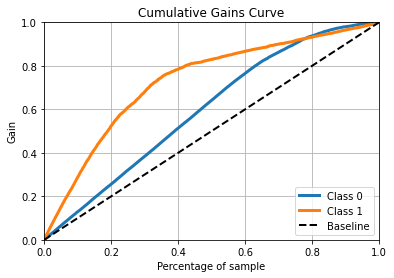

In [16]:
y_probas = clf.predict_proba(X_test)


import matplotlib.pyplot as plt
import scikitplot as skplt
skplt.metrics.plot_cumulative_gain(y_test, y_probas, figsize= (6,4))
plt.show()

La création d'une courbe lift cumulée permet de voir quel pourcentage de clients sera atteint en fonction d'une taille de cible choisie. Si on choisit les 20% de produits ayant le meilleur score on réussit à atteindre 60% de bonnes prédictions.

# Support Vector Machine (SVM)

Nous testons une autre méthode de classification : Support Vector Machine (SVM). L'algorithme SVM sépare les données en classes à l’aide d’une frontière aussi « simple » que possible, de telle façon que la distance entre les différents groupes de données et la frontière qui les sépare soit maximale. Cette distance est aussi appelée « marge » et les SVMs sont ainsi qualifiés de « séparateurs à vaste marge », les « vecteurs de support » étant les données les plus proches de la frontière. Il convient dans un premier temps de préparer les données :

In [15]:
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import svm
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, train_size = 0.2)
X_train_scaled = preprocessing.scale(X_train)
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

Et nous testons le modèle qui affichera la matrice de confusion

In [16]:
clf = svm.SVC(gamma=0.01,  kernel='poly')
clf.fit(X_train_scaled, y_train)
y_pred = clf.predict(X_test_scaled)
pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])

Classe prédite,0,1
Classe réelle,,
0,22299,0
1,9244,89


_La matrice de confusion présente une faiblesse avec trop peu de suggestions réussies (valeur 1). Nous allons à présent améliorer le modèle._

In [17]:
parametres = {'C':[0.1,1,10],'kernel':['rbf','linear', 'poly'], 'gamma':[0.001, 0.1, 0.5]}
grid_clf = model_selection.GridSearchCV(estimator=clf, param_grid=parametres)
grille = grid_clf.fit(X_train_scaled,y_train)

In [18]:
print(grid_clf.best_params_)

{'C': 10, 'gamma': 0.5, 'kernel': 'rbf'}


In [19]:
y_pred = grid_clf.predict(X_test_scaled)
pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])

Classe prédite,0,1
Classe réelle,,
0,21012,1287
1,4728,4605


In [20]:
print(pd.DataFrame.from_dict(grille.cv_results_).loc[:,["params","mean_test_score"]]) 

                                            params  mean_test_score
0      {'C': 0.1, 'gamma': 0.001, 'kernel': 'rbf'}         0.699507
1   {'C': 0.1, 'gamma': 0.001, 'kernel': 'linear'}         0.769699
2     {'C': 0.1, 'gamma': 0.001, 'kernel': 'poly'}         0.698622
3        {'C': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}         0.738208
4     {'C': 0.1, 'gamma': 0.1, 'kernel': 'linear'}         0.769699
5       {'C': 0.1, 'gamma': 0.1, 'kernel': 'poly'}         0.703554
6        {'C': 0.1, 'gamma': 0.5, 'kernel': 'rbf'}         0.771343
7     {'C': 0.1, 'gamma': 0.5, 'kernel': 'linear'}         0.769699
8       {'C': 0.1, 'gamma': 0.5, 'kernel': 'poly'}         0.710384
9        {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}         0.705704
10    {'C': 1, 'gamma': 0.001, 'kernel': 'linear'}         0.789933
11      {'C': 1, 'gamma': 0.001, 'kernel': 'poly'}         0.698622
12         {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}         0.775770
13      {'C': 1, 'gamma': 0.1, 'kernel': 'linear

_La nouvelle matrice de confusion présente un modèle plus performant, avec les hyperparamètres {'C': 10, 'gamma': 0.5, 'kernel': 'rbf'}, nous obtenons un score de 81,47%._

**_Les 3 méthodes de prédiction sont toutes performantes avec un avantage minime pour la méthode Random Forest._**

# Machine Learning

* Création d'un dataframe qui contient les utilisateurs qui ont réalisé au moins 10 interactions afin d'éliminer les utilisateurs les moins significatifs :

In [23]:
user_value_counts = df_events['visitorid'].value_counts()
data = df_events[df_events['visitorid'].isin(user_value_counts[user_value_counts >= 10].index)]

* On souhaite réaliser notre modèle de recommandation sur la base des utilisateurs ayant réalisé un achat :

In [24]:
#Selection des utilisateurs ayant réalisé un achat
customer_purchased = data[data.transactionid.notnull()].visitorid.unique()
    
purchased_items = []
buyer = []

    
# Création d'une liste qui contient leurs achats
for customer in customer_purchased:
    buyer.append(customer)
    purchased_items.append(list(data.loc[(data.visitorid == customer) & (data.transactionid.notnull())].itemid.values)) 

* Création d'un dataframe qui contient la liste des items achetés par chaque visiteur :

In [25]:
purchased_items_df = pd.DataFrame({"Item acheté":purchased_items})
buyer_df = pd.DataFrame({"visitorid":buyer, "Item acheté":purchased_items})
buyer_df.head()


,visitorid,Item acheté
0,599528,[356475]
1,121688,"[15335, 380775, 237753, 317178, 12836, 400969,..."
2,189384,"[310791, 299044]"
3,350566,"[54058, 284871, 251130, 268335, 183049, 261940..."
4,404403,"[150100, 50934, 36013, 26210, 118199, 234199, ..."


* Ajout du cluster d'appartenance du visiteur :

In [26]:
buyer_df = buyer_df.merge(right = df_id, on = 'visitorid', how = 'outer' )
buyer_df = buyer_df.drop(["Nombre de vues", "Nombre d'ajout au panier",
                          "Nombre de transactions", "cen_x", "cen_y" , "c" ], axis = 1)

In [27]:
buyer_df.head()

,visitorid,Item acheté,cluster
0,599528,[356475],0
1,121688,"[15335, 380775, 237753, 317178, 12836, 400969,...",0
2,189384,"[310791, 299044]",0
3,350566,"[54058, 284871, 251130, 268335, 183049, 261940...",1
4,404403,"[150100, 50934, 36013, 26210, 118199, 234199, ...",3


* On applique l'algorithme **Apriori** afin de créer un moteur de suggestion produits sur la base des produits déjà achetés :

_Apriori est un algorithme utilisé pour extraire des ensembles d'éléments fréquents dans l'apprentissage de règles
d'association.  Un ensemble d'éléments est considéré comme "fréquent" s'il atteint un seuil de prise
en charge spécifié par l'utilisateur.
Par exemple, si le seuil de prise en charge (support) est défini sur 0,5 (50%), un ensemble d'éléments fréquents est défini comme un ensemble d'éléments qui se produisent ensemble dans au moins 50% de toutes les transactions de la base de données._

**L'idée principale d'Apriori est la suivante :**

Tous les sous-ensembles non vides d'un ensemble d'éléments fréquents doivent également être fréquents.

Il sagit d'une approche ascendante. Nous sommes partis de chaque item de la liste d'items. Ensuite, les candidats sont générés par auto-adhésion. Nous étendons la longueur des itemsets un item à la fois. Le test de sous-ensembles est effectué à chaque étape et les ensembles d'items qui contiennent des sous-ensembles peu fréquents sont élagués. Nous répétons le processus jusqu'à ce qu'il ne soit plus possible de dériver d'itemsets à partir des données.

In [28]:
#Importation d'apriori
pip install mlxtend

* On doit d'abord transformer les données en matrice pour être exploitées :

In [29]:
#importation d'apriori
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules , fpgrowth

#Transformation
te = TransactionEncoder()
te_ary = te.fit(purchased_items).transform(purchased_items)
df = pd.DataFrame(te_ary, columns=te.columns_)
df

,15,19,25,42,147,168,212,233,320,387,...,466161,466259,466263,466319,466321,466443,466464,466526,466603,466614
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3785,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3786,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3787,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3788,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


**Création d'un dataset qui regroupe les objets les plus souvent achetés ensemble et leur nombre**

Dans l'algorithme **Apriori**, deux eléments sont primordiaux :

* **Le support** : Ici cela represente la probabilité qu'un produit ait été acheté, ou qu'un ensemble de produits ait été acheté. Plus sa valeur est proche de 1 plus ce produit ou cet ensemble est important. 


* **La confiance** : Ici cela représente la probabilité conditionnelle qu'une transaction qui contient le produit {A} contienne aussi le produit {B}. Si la confiance est de 1 cela signifie que le produit {A} a toujours été acheté avec le produit {B}.


In [30]:
#Rappel des produits les plus achetés
df_events[df_events.events_transaction == 1].itemid.value_counts()

461686    133
119736     97
213834     92
312728     46
7943       46
         ... 
457622      1
324946      1
299915      1
97158       1
329729      1
Name: itemid, Length: 12025, dtype: int64

_Rappel : Sur un Total de 12025 produits acheté et 22457 transactions, le produit le plus acheté {461686} a été acheté 133 fois._

Le seuil de prise en charge (support) que nous allons définir va donc être faible car aucun produit a une très forte influence sur l'ensemble de données.

In [31]:
#On défini le seuil minimum de prise en charge sur 0.001
frequent_itemsets = apriori(df, min_support=0.001, use_colnames=True)
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))

#affichage des Item par odre d'importance
frequent_itemsets.sort_values(['support'], ascending=False)
proba = 0.019525 * 100
print("Le produit qui revient le plus souvent a une probabilité de", proba, " % d'être acheté" )
frequent_itemsets.sort_values(['support'], ascending=False)


Le produit qui revient le plus souvent a une probabilité de 1.9525000000000001  % d'être acheté


,support,itemsets,length
342,0.019525,(461686),1
153,0.011082,(213834),1
86,0.010554,(119736),1
325,0.005805,(445351),1
311,0.005277,(420960),1
...,...,...,...
206,0.001055,(276704),1
208,0.001055,(281480),1
209,0.001055,(283115),1
213,0.001055,(289096),1


On peut aussi observer la faible importance des achats groupés sur l'ensemble des achats :

In [32]:
frequent_itemsets[frequent_itemsets.length > 1].sort_values(['support'], ascending=False)

,support,itemsets,length
410,0.005013,"(213834, 445351)",2
400,0.002111,"(119736, 420960)",2
377,0.002111,"(119736, 213834)",2
366,0.002111,"(119736, 46156)",2
404,0.002111,"(171878, 461686)",2
...,...,...,...
397,0.001055,"(119736, 384302)",2
356,0.001055,"(119736, 12217)",2
399,0.001055,"(399592, 119736)",2
355,0.001055,"(445351, 11279)",2


* **Affichage des résultats, avec pour chaque produit acheté (antecedents) une ou plusieurs propositions de produits (consequents) susceptibles d'intéresser les acheteurs :**

Afin d'affiner les résultats, on defini un seuil (min_threshold) que l'on applique a un indicateur donné (ici l'indicateur est la **confiance** que l'on a évoqué précédemment). Le seuil a été defini sur 0.2 donc 20%, cela signifie que l'algorithme va retourner les résultats pour les produits qui ont au minimum déjà été acheté ensemble dans **20 %** des cas.

In [33]:
rules_ap = association_rules(frequent_itemsets, metric ="confidence", min_threshold = 0.2)
rules_ap

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(546),(119736),0.003166,0.010554,0.001319,0.416667,39.479167,0.001286,1.696193
1,(546),(248455),0.003166,0.004222,0.001055,0.333333,78.958333,0.001042,1.493668
2,(248455),(546),0.004222,0.003166,0.001055,0.250000,78.958333,0.001042,1.329112
3,(546),(338660),0.003166,0.002639,0.001055,0.333333,126.333333,0.001047,1.496042
4,(338660),(546),0.002639,0.003166,0.001055,0.400000,126.333333,0.001047,1.661390
...,...,...,...,...,...,...,...,...,...
141,(384302),"(119736, 338660)",0.002111,0.001319,0.001055,0.500000,379.000000,0.001053,1.997361
142,"(213834, 268883)",(445351),0.001055,0.005805,0.001055,1.000000,172.272727,0.001049,inf
143,"(213834, 445351)",(268883),0.005013,0.004222,0.001055,0.210526,49.868421,0.001034,1.261319
144,"(268883, 445351)",(213834),0.001055,0.011082,0.001055,1.000000,90.238095,0.001044,inf


**Présentation des différents indicateurs :**



* Les colonnes **antecedents** et **consequents** contiennent les Itemid:
         Antecedent = Le produit d'entrée, qui conduit à la recommandation
         Consequent = Le produit recommandé en fonction de l'antecedent

* Il existe 3 indicateurs de supports : l'indicateur de l'antecedent, du consequent ainsi que du couple antecedent/consequent.

Comme expliqué précédemment le **support** représente la fréquence (ou l'importance) d'un item dans la base de données.

* La **confidence** représente la probabilité de voir le consequent dans une transaction donne qui contient également l'antecedent.
Par exemple le produit (119736) a une probabilité de 41% d'etre acheté si le produit (546) a deja été acheté par cet utilisateur.

* Le **lift** est un indicateur utilisé pour mesurer combien de fois l'antecedent et le consequent seraient achetés ensemble si ils étaient statistiquement indépendants. Si {A} et {C} sont indépendants, le score **lift** sera exactement 1.

* Le **leverage** est un indicateur qui calcule la différence entre la fréquence observée de {A} et {C} apparaissant ensemble et la fréquence attendue si A et C sont indépendants. Une valeur de 0 indique l'indépendance.

* La **conviction** est un indicateur qui mesure la dépendance du consequent a l'antecedent. Une valeur de conviction élevée signifie que le consequent dépend fortement de l'antecedent. Par exemple, dans le cas d'un score de confiance parfait, le dénominateur devient 0 (en raison de 1 - 1) pour lequel le score de conviction est défini comme «inf». Comme le lift, si les éléments sont indépendants, la conviction est de 1.